In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Download necessary NLTK packages
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Extraction Features

In [2]:
df = pd.read_csv("processed_data/Resume_proc_lemm.csv")

In [3]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

In [4]:
count_vect = CountVectorizer(
        lowercase=True,
        binary = False,
        # max_features = 10000,
        stop_words = list(stop_words),          # TODO could be not useful, we already remove stop words in preprocess_text
        ngram_range=(1,6),                      # Considers unigrams and bigrams
        max_df = 0.8,                           # Ignores words appearing in more than 85% of documents (too common)
        min_df = 2                              # Keeps words appearing in at least 2 documents (filters rare words)
    )

In [5]:
resume_countvectorizer = count_vect.fit_transform(df['Resume_str'])

In [6]:
len(count_vect.vocabulary_)

375783

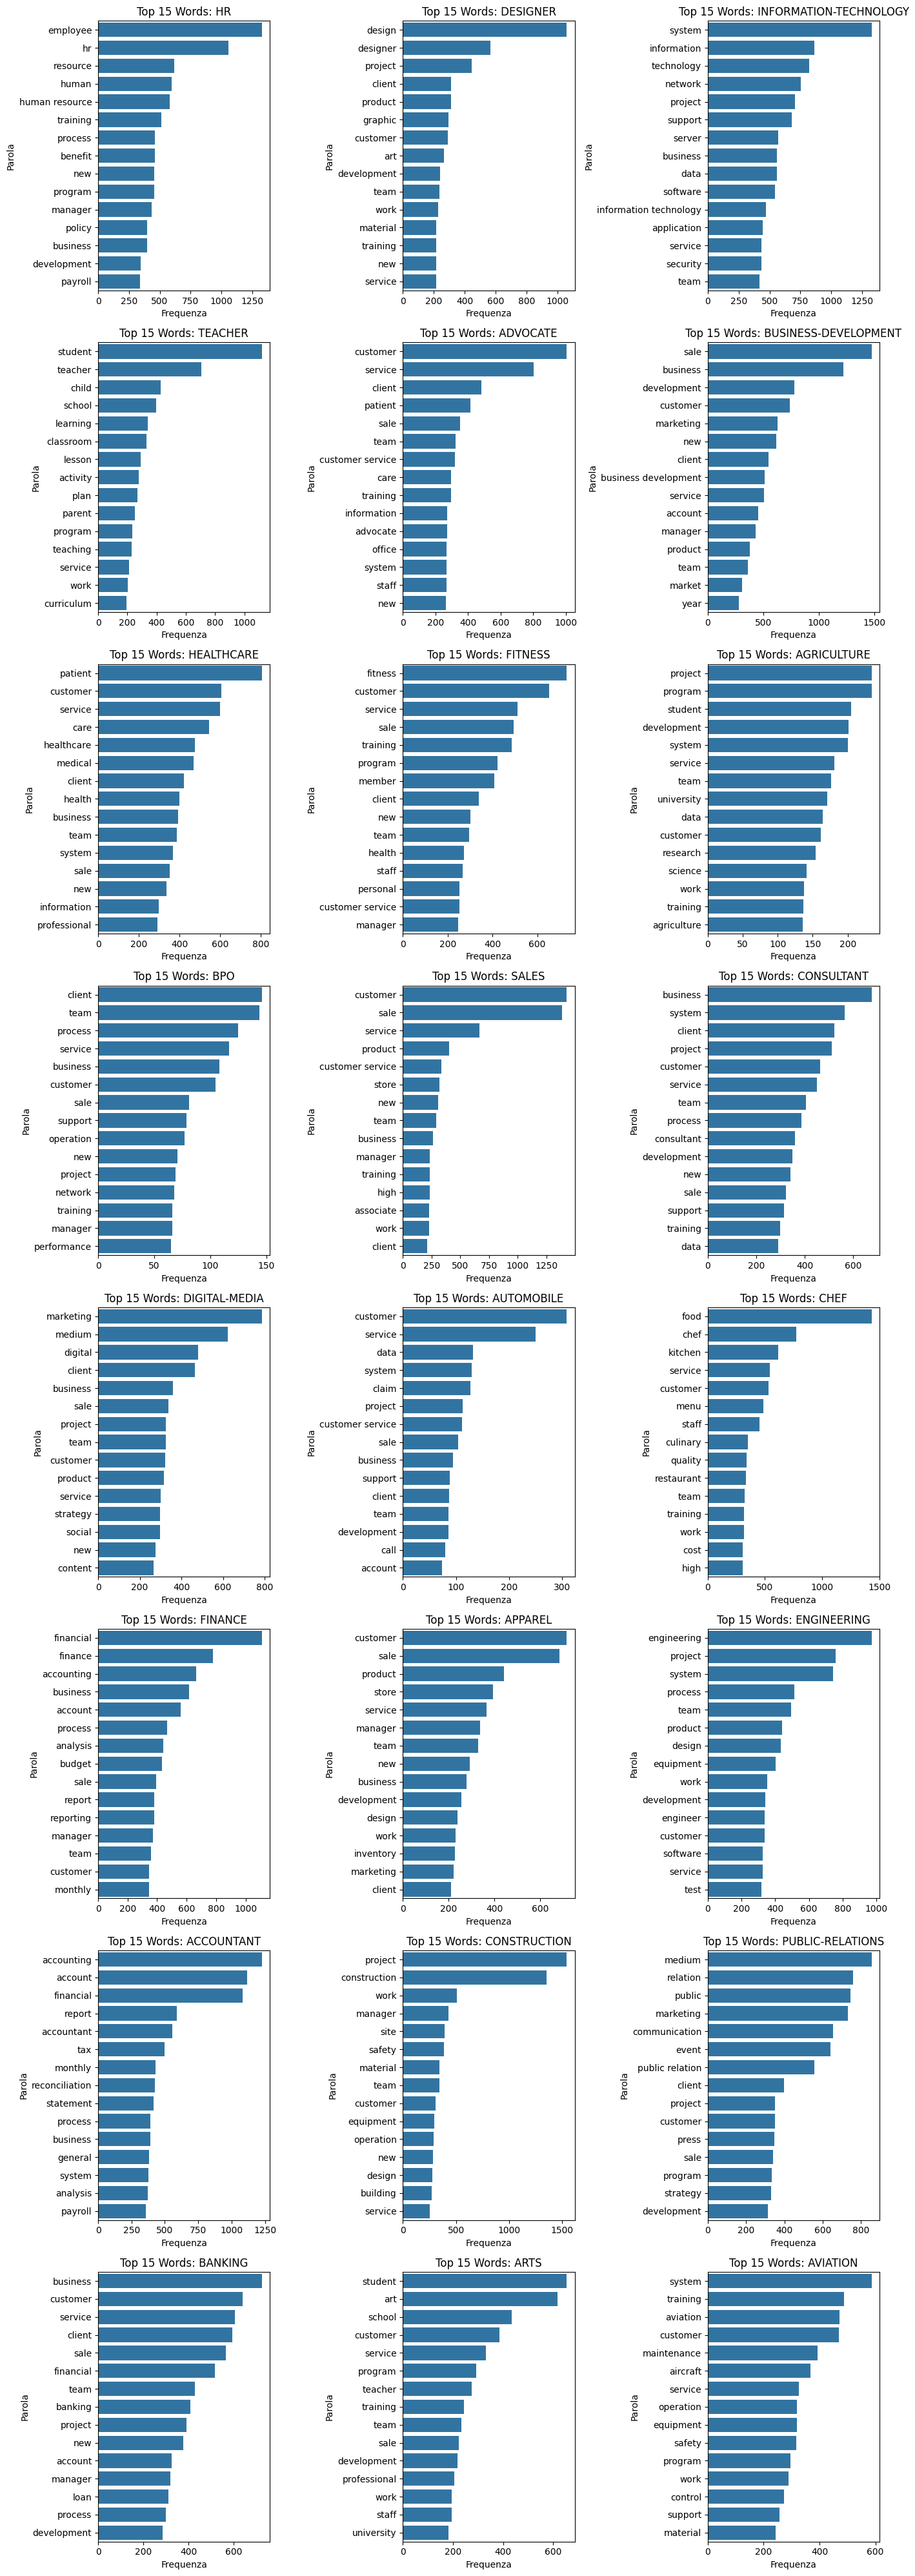

In [7]:

# 1. Recupera i nomi delle feature
feature_names = count_vect.get_feature_names_out()

# 2. Trasforma in DataFrame
resume_df = pd.DataFrame(resume_countvectorizer.toarray(), columns=feature_names)

# 4. Parametri
top_n = 15
categories = df['Category'].unique()
n = len(categories)

cols = 3
rows = math.ceil(n / cols)

# 5. Crea figura e assi
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# 6. Per ogni categoria, crea il bar chart nello subplot
for idx, category in enumerate(categories):
    cat_df = resume_df[df['Category'] == category]
    word_freq = cat_df.sum().sort_values(ascending=False).head(top_n)

    sns.barplot(x=word_freq.values, y=word_freq.index, ax=axes[idx])
    axes[idx].set_title(f"Top {top_n} Words: {category}")
    axes[idx].set_xlabel("Frequenza")
    axes[idx].set_ylabel("Parola")

# 7. Disattiva subplot vuoti
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

# 8. Spaziatura tra le righe
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.show()

In [8]:
tfidf_transformer = TfidfTransformer()
resume_tfidf = tfidf_transformer.fit_transform(resume_countvectorizer).toarray()

In [9]:
pca = PCA(n_components=2)
resume_pca = pca.fit_transform(resume_tfidf)

In [10]:
# Categorie da visualizzare
categorie_da_visualizzare = ['ARTS', 'TEACHER']

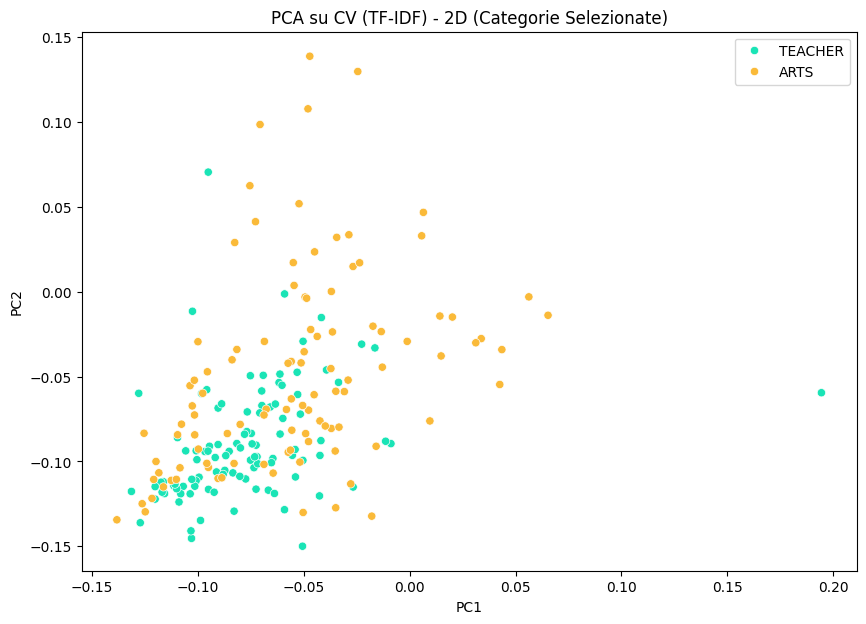

In [11]:
# Filtro il DataFrame e X_pca per le categorie selezionate
maschera = df['Category'].isin(categorie_da_visualizzare)
resume_pca_filtrato = resume_pca[maschera]
df_filtrato = df[maschera]

# 2. PCA per ridurre a 2D
# Visualizzazione 2D
plt.figure(figsize=(10,7))
sns.scatterplot(x=resume_pca_filtrato[:,0], y=resume_pca_filtrato[:,1], hue=df_filtrato['Category'], palette='turbo')
plt.title('PCA su CV (TF-IDF) - 2D (Categorie Selezionate)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.show()

In [12]:
# 3. PCA per ridurre a 3D
# PCA per ridurre a 3D
pca_3d = PCA(n_components=3)
resume_pca_3d = pca_3d.fit_transform(resume_tfidf)

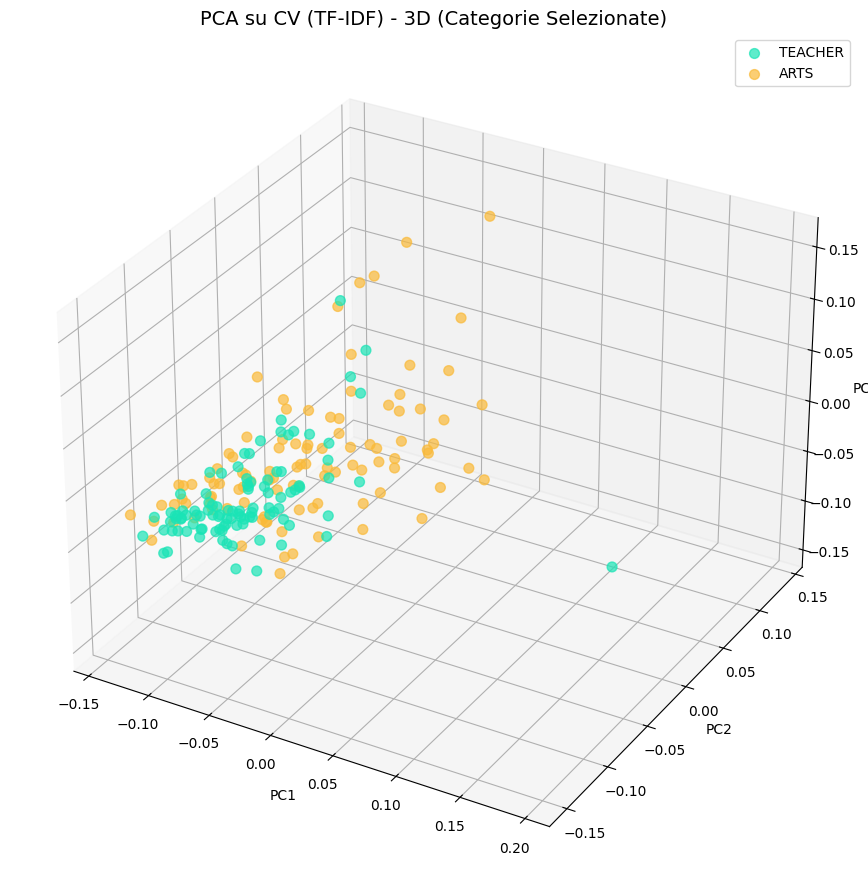

In [13]:
# Filtrare anche i dati per 3D
resume_pca_3d_filtrato = resume_pca_3d[maschera]

# Visualizzazione 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Mappa colori per categoria
palette = sns.color_palette('turbo', n_colors=len(df_filtrato['Category'].unique()))
colori = dict(zip(df_filtrato['Category'].unique(), palette))

# Scatter 3D
for categoria in df_filtrato['Category'].unique():
    idx = df_filtrato['Category'] == categoria
    ax.scatter(
        resume_pca_3d_filtrato[idx, 0],
        resume_pca_3d_filtrato[idx, 1],
        resume_pca_3d_filtrato[idx, 2],
        label=categoria,
        color=colori[categoria],
        s=50,  # dimensione punti
        alpha=0.7
    )

# Label e titolo
ax.set_title('PCA su CV (TF-IDF) - 3D (Categorie Selezionate)', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
resume_tsne = tsne.fit_transform(resume_tfidf)

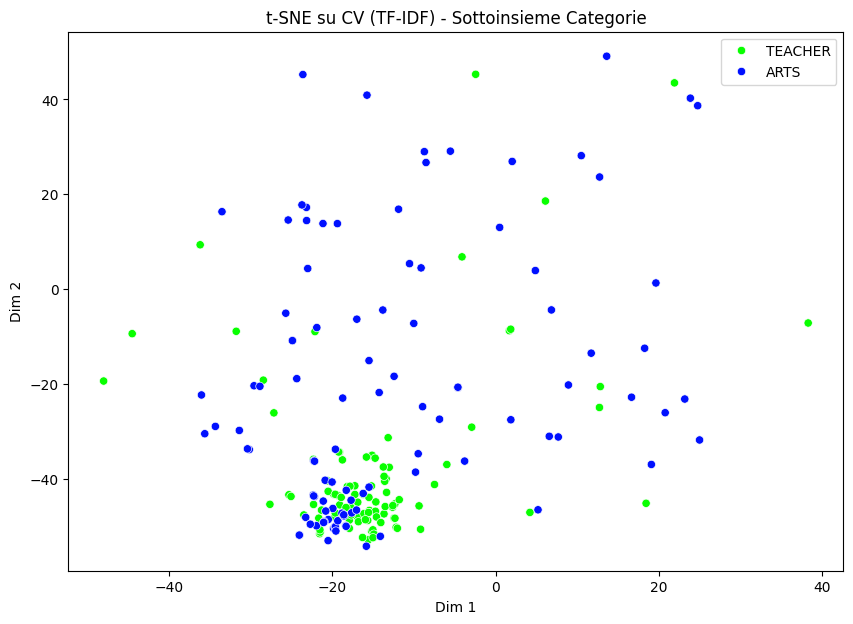

In [15]:
# Applica la maschera sia al DataFrame che a X_tsne
resume_tsne_filtrato = resume_tsne[maschera]
df_filtrato = df[maschera]

# Ora fai il plot solo con il sottoinsieme
plt.figure(figsize=(10,7))
sns.scatterplot(x=resume_tsne_filtrato[:,0], y=resume_tsne_filtrato[:,1], hue=df_filtrato['Category'], palette='hsv')
plt.title('t-SNE su CV (TF-IDF) - Sottoinsieme Categorie')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(loc='best')
plt.show()

In [16]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
resume_tsne_3d = tsne.fit_transform(resume_tfidf)

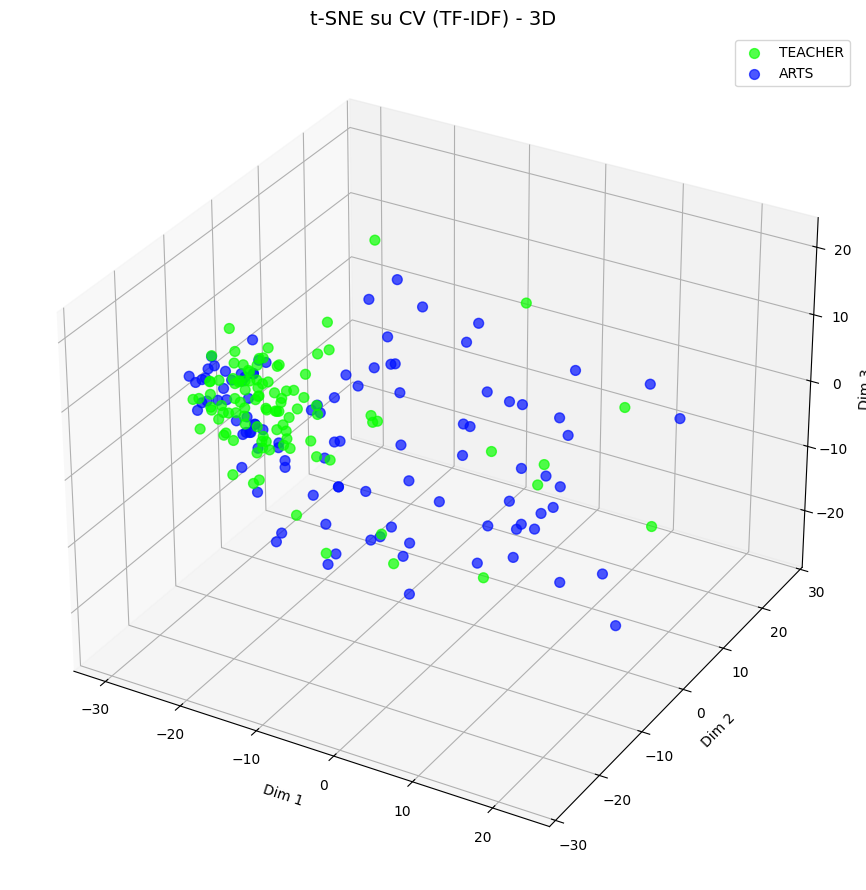

In [17]:
resume_tsne_3d_filtrato = resume_tsne_3d[maschera]

# Plot 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Mappa colori per categoria
palette = sns.color_palette('hsv', n_colors=len(df_filtrato['Category'].unique()))
colori = dict(zip(df_filtrato['Category'].unique(), palette))

# Scatter 3D
for categoria in df_filtrato['Category'].unique():
    idx = df_filtrato['Category'] == categoria
    ax.scatter(
        resume_tsne_3d_filtrato[idx, 0],
        resume_tsne_3d_filtrato[idx, 1],
        resume_tsne_3d_filtrato[idx, 2],
        label=categoria,
        color=colori[categoria],
        s=50,  # dimensione punti
        alpha=0.7
    )

# Label e titolo
ax.set_title('t-SNE su CV (TF-IDF) - 3D', fontsize=14)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.legend(loc='best')
plt.tight_layout()
plt.show()
